# World Settlement Footprint -  Evolution
* **Products used:** 
[wsf_evolution](https://explorer.digitalearth.africa/products/wsf_evolution)

## Background

According to the UN Department of Economics and Social Affairs, 9.7 billion people will inhabit the planet by the year 2050. 55% of the world's population presently resides in urban areas, and by 2050, that number is projected to increase to 68%. Rapid and haphazard urbanization, when paired with the problems posed by climate change, can increase air pollution, make people more susceptible to catastrophes, and cause problems with the management of resources like water, raw materials, and energy (Mapping Our Human Footprint From Space, 2023).

To improve the understanding of current trends in global urbanisation, ESA and the German Aerospace Center (DLR), in collaboration with the Google Earth Engine team, are jointly developing the World Settlement Footprint – the world’s most comprehensive dataset on human settlement (G.D.Team, 2023).

The **World Settlement Footprint Evolution** was produced by processing seven million images from the US Landsat satellite collected between 1985 and 2015 and shows the annual growth of human settlements globally (Mapping Our Human Footprint From Space, 2023). It is worth noting that **past Landsat-5/7 availability** considerably varies across the world and over time. Independently from the implemented approach, this might then result in a lower quality of the final product where few/no scenes have been collected. To provide the users with a suitable and intuitive measure that accounts for the goodness of the Landsat imagery, the **Input Data Consistency (IDC) score,which ranges from 6 to 1 with: 6) very good; 5) good; 4) fair; 3) moderate; 2) low; 1) very low**. The IDC score is available on a yearly basis between 1985 and 2015 and supports a proper interpretation of the WSF evolution product  (G.D.Team, 2023).

The World Settlement Footprint evolution data are now indexed in the DE Africa platform.

## Description

This notebook is a walkthrough on how to use the World Settlement Footprint  and evolution data in the data cube. The worked example takes users through the code required to:
 
   1. Inspecting the WSF data in the datacube
   2. Use `dc.load()` function to load in WSF data
   3. Plotting of results for WSF data

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from datacube.utils.geometry import Geometry

from deafrica_tools.plotting import display_map
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="wsf")

### List measurements

We can inspect the data available for WSF using datacube's `list_measurements` functionality. The table below lists the products and measurements available for the three WSF datasets indexed within DE Africa's datacube. 

In [3]:
product_name = ['wsf_evolution'] 

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name  dtype units  nodata  \
product       measurement                                       
wsf_evolution wsfevolution  wsfevolution  int32     1     0.0   
              idc_score        idc_score  uint8     1     0.0   

                                          aliases  
product       measurement                          
wsf_evolution wsfevolution         [wsfevolution]  
              idc_score     [idc, idcscore, idcs]

### Analysis parameters

To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

The default location is Kumasi, Ashanti Region, Ghana

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
# aoi = define_area(lat= 6.69856, lon=-1.62331, buffer=0.2)
aoi = define_area(lat= 30.9588, lon=31.2561, buffer=0.2)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# defining the color scheme for wfs 2015 and 2019 plotting
ft_2015 = '#D3D3D3'
ft_2019 = '#e5ab00'

### View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Loading of the WSF Dataset

The WSF dataset will be loaded using the `dc.load` function. For more discussion on how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

The cell below loads the wsf_evolution dataset. Notice the `product` and `measurements` values. 
These will be updated for the subsequent data when they are being loaded.

In [6]:
#create reusable datacube query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution':(-30, 30),
    'output_crs': 'epsg:6933',
}

#loading the data using dc.load
wsf_evolution = dc.load(product='wsf_evolution',
                        measurements=['wsfevolution', 'idc_score'],
                        **query).squeeze()

display(wsf_evolution)

<xarray.Dataset>
Dimensions:       (y: 1465, x: 1288)
Coordinates:
    time          datetime64[ns] 2000-07-01T23:59:59.999500
  * y             (y) float64 3.786e+06 3.786e+06 ... 3.743e+06 3.743e+06
  * x             (x) float64 2.996e+06 2.997e+06 ... 3.035e+06 3.035e+06
    spatial_ref   int32 6933
Data variables:
    wsfevolution  (y, x) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    idc_score     (y, x) uint8 5 5 5 5 5 5 5 5 5 5 5 5 ... 6 6 6 6 6 6 6 6 6 6 6
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

### Calculate the area of the building footprint

The number of pixels can be used for the area of the building if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [7]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Spatial Plotting of WSF-Evolution data
WSF-Evolution is a time-step dataset where each pixel represents the year of evolution and a `0` pixel value is no data. The cell below plots out the dataset and shows how the building footprint has evolved over the years from 1985 to 2015. It is worth noting that past Landsat-5/7 availability considerably varies across the world and over time. Independently from the implemented approach, this might then result in a lower quality of the final product where few/no scenes have been collected.
**Input Data Consistency (IDC) score,which ranges from 6 to 1 with: 
6 - very good; 
5 - good; 
4 - fair; 
3 - moderate; 
2 - low; 
1 - very low**. 
The IDC score supports a proper interpretation of the WSF evolution product.

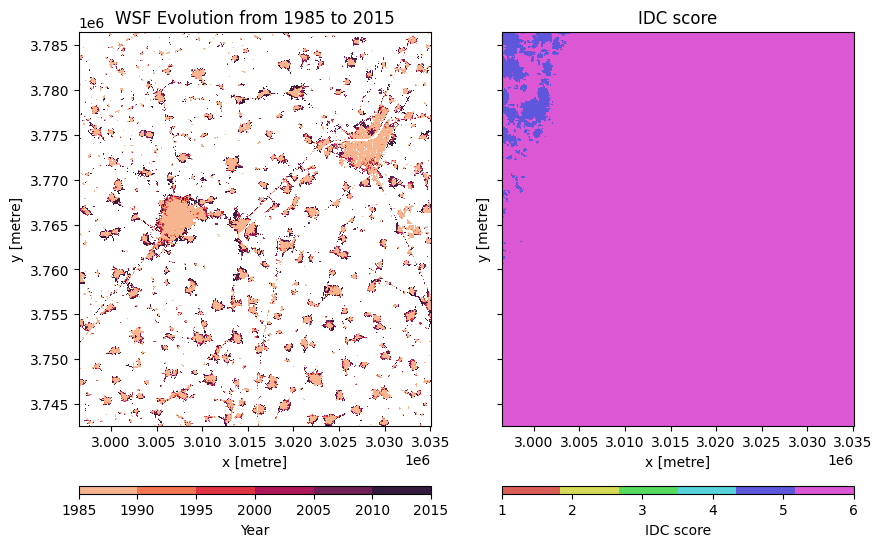

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

#in plotting of te data zero(no-data) is marked out 
wsf_plt = wsf_evolution.where(wsf_evolution != 0
                             ).wsfevolution.plot(cmap=ListedColormap(
    sns.color_palette('rocket_r').as_hex()), ax=ax[0], add_colorbar= False)

ax[0].set_title('WSF Evolution from 1985 to 2015')
 
divider = make_axes_locatable(ax[0])
cax = divider.new_vertical(size='2%', pad=0.6, pack_start = True)
fig.add_axes(cax)
fig.colorbar(wsf_plt, cax = cax, orientation = 'horizontal', label='Year')


#in plotting of the IDC score to support interpretation of the data
wsf_plt = wsf_evolution.where(wsf_evolution != 0
                             ).idc_score.plot(cmap=ListedColormap(
    sns.color_palette('hls', 6).as_hex()), ax=ax[1], add_colorbar= False,  vmin=1, vmax=6)

ax[1].set_title('IDC score')

divider = make_axes_locatable(ax[1])
cax = divider.new_vertical(size='2%', pad=0.6, pack_start = True)
fig.add_axes(cax)
fig.colorbar(wsf_plt, cax = cax, orientation = 'horizontal', label='IDC score')

plt.show()

### Plotting of the WSF-Evolution data

Each pixel represents the year value of the WSF evolution dataset; to get the area of the evolution, the year pixel has to be counted and saved in a Pandas dataframe to enable calculation of the area. The cumulative sum of area will be calculated based on how it has increased over the period.

>Note that there is a discrepancy between the area calculated for 2015 from the WSF 2015 product and the Evolution product. This may be because the Evolution product is derived from Landsat-5 and Landsat-7, whereas WSF 2015 and 2019 are derived from Sentinel-1 and Landsat-8.

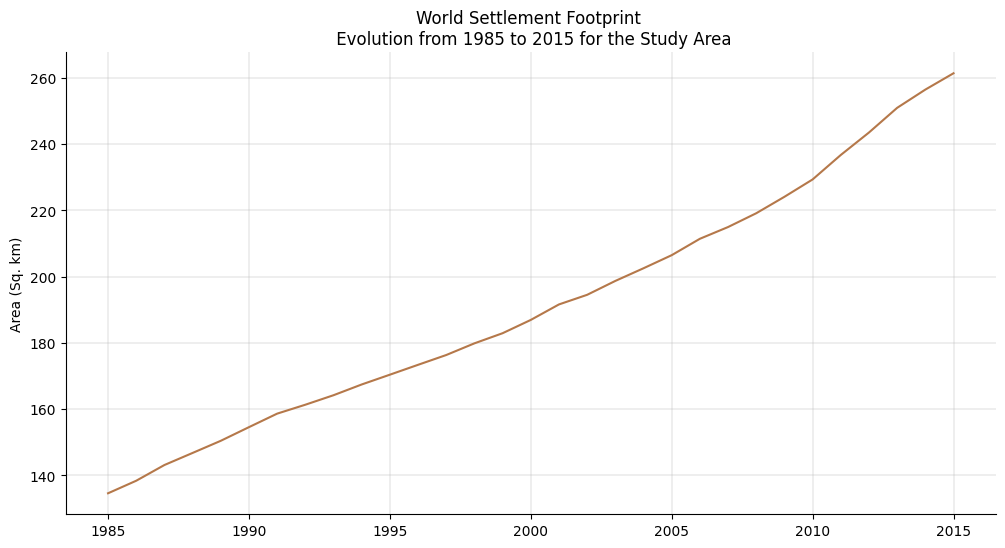

In [9]:
evolution_period = {}
#running a for loop to extract year and calculate the area based on the year
for evolution_year in np.unique(wsf_evolution.wsfevolution.values):
    if evolution_year != 0:
        evolution_area = wsf_evolution.where(
            wsf_evolution.wsfevolution ==evolution_year).wsfevolution.count() * area_per_pixel
        evolution_period[evolution_year] = evolution_area

#convert dict to dataframe
evolution_data = pd.DataFrame.from_dict(evolution_period, orient='index', dtype=float)

#Cummulative sum of the data
evolution_data['evolve'] = evolution_data[0].cumsum()

fig, ax = plt.subplots(figsize=(12,6))

evolution_data.evolve.plot(ax=ax, color='#B5784A')

ax.set_ylabel("Area (Sq. km)")
ax.set_title(f"World Settlement Footprint \n Evolution from 1985 to 2015 for the Study Area")
ax.grid(linewidth=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

>It is worth noting that past Landsat-5/7 availability considerably varies across the world and over time. Independently from the implemented approach, this might then result in a lower quality of the final product where few/no scenes have been collected. The **IDC score** supports a proper interpretation of the WSF evolution product.

### Animation of WSF-Evolution data from 1985 to 2015
The cell below plots out the dataset and shows the animation of how the building footprint has evolved over the years from 1985 to 2015.

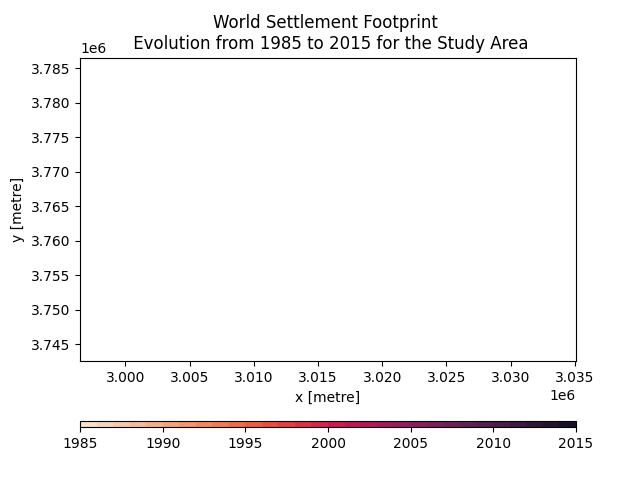

In [10]:
evolution_year = evolution_data.index.values
fig, ax = plt.subplots()

#Generating the color scheme based on the number of years
lenyear=len(evolution_year)
palette = list(reversed(sns.color_palette("rocket", lenyear).as_hex()))
wsf = []
color_index = 0
for i in range(1, len(evolution_year) + 1):
    evo_list= (evolution_year[:i])
    color = palette[:color_index]
    wsf_plt = wsf_evolution.where(
        wsf_evolution.isin(evo_list)).wsfevolution.plot(cmap=ListedColormap(color),
                                                 add_colorbar= False, ax=ax)
    color_index += 1
    wsf.append([wsf_plt])

ax.set_title('World Settlement Footprint \n Evolution from 1985 to 2015 for the Study Area')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='2%', pad=0.6, pack_start = True)
fig.add_axes(cax)
fig.colorbar(wsf_plt, cax = cax, orientation = 'horizontal')

ani = animation.ArtistAnimation(fig=fig, artists=wsf, interval=500, blit=True)
ani.save('wsf.gif')
plt.close()

Image(filename='wsf.gif')

### Conclusion

The World Settlement Footprint offers a knowledge base that can help researchers, governmental organizations, and other stakeholders, such as urban planners, better understand how urbanization is happening and, concurrently, put in place sustainable urban development strategies for informed policy decisions at local and national levels.


**Note**

To run for different area go to cell **Analysis parameters**, change the **lat** and **lon** values in the **define_area_function**.

#### Referencing

Mapping our human footprint from space. (n.d.). ESA - Mapping Our Human Footprint From Space. https://www.esa.int/Applications/Observing_the_Earth/Mapping_our_human_footprint_from_space

Marconcini, M., Metz-Marconcini, A., Üreyen, S. et al. Outlining where humans live, the World Settlement Footprint 2015. Sci Data 7, 242 (2020). https://doi.org/10.1038/s41597-020-00580-5

Mattia Marconcini, Annekatrin Metz-Marconcini, Thomas Esch and Noel Gorelick. Understanding Current Trends in Global Urbanisation - The World Settlement Footprint Suite. GI_Forum 2021, Issue 1, 33-38 (2021) https://austriaca.at/0xc1aa5576%200x003c9b4c.pdf

Team, G. D. (n.d.). EOC Geoservice Map Contexts. EOC Geoservice Map Contexts. https://geoservice.dlr.de/web/maps

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [11]:
print(datacube.__version__)

1.8.15


**Last tested:**

In [12]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-10-09'